This is my first attempt at using pandas and since using it I've realised that the way to organise this data is probably to put all the different runs into a single data frame, with a multiindex that has the pdb_code as the first level and the runtype ('quark', 'metapsicov', etc.) as the second. All operations would then apply to a single dataframe.

In [1]:
from __future__ import print_function
from collections import OrderedDict
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import matplotlib.patches as mpatches
%matplotlib inline

COLOUR_SUCCESS = 'blue'
COLOUR_FAIL = 'red'
DPI=600

In [2]:
def process_df(df):
    """Remove unwanted targets and add success criteria"""

    df['SHELXE_OK'] = (df.SHELXE_CC >= 25) & (df.SHELXE_ACL >= 10)
    # or use df_unsucc = df.query("successful == 0")
    df[['SXRARP_final_Rfree', 'SXRBUCC_final_Rfree']] = df[['SXRARP_final_Rfree', 'SXRBUCC_final_Rfree']].fillna(1.0)
    df['MIN_RFREE'] = df[['SXRARP_final_Rfree', 'SXRBUCC_final_Rfree']].min(axis=1)
    df['REBUILD_OK'] = df['MIN_RFREE'] < 0.45
    df['REFMAC_OK'] = df['REFMAC_Rfree'] <= 0.45
    df['PHASER_OK'] = (df.PHASER_TFZ >= 8.0) | (df.PHASER_LLG > 120)
    df['success'] = (df.SHELXE_OK  & df.REBUILD_OK)
    
    # Need to delete 2UUI, 2BL2, 2X2V
    #df = df[(df['native_pdb_code'] != '2BL2') & (df['native_pdb_code'] != '2UUI') & (df['native_pdb_code'] != '2X2V')]
    #df['native_pdb_code'].drop(-df['native_pdb_code'].isin(['2BL2','2UUI','2X2V']),inplace=True)
    df = df[-df['native_pdb_code'].isin(['2BL2','2UUI','2X2V'])]
    return df

In [3]:
def summarise_df(df):
    df.sort_values(['native_pdb_code', 'success', 'SHELXE_CC'], ascending=[1,0,0], inplace=True)
    group = df.groupby(['native_pdb_code'])
    sdf = group.first()[['native_pdb_resolution','native_pdb_num_residues','ensemble_name','num_residues','subcluster_num_models','PHASER_LLG','PHASER_TFZ', 'PHASER_RFZ', 'SHELXE_CC', 'SHELXE_ACL','SXRBUCC_final_Rfree','SXRARP_final_Rfree']]
    sdf['success'] = group['success'].sum()
    sdf['num_models'] = group['native_pdb_code'].size()
    sdf['PHASER_OK'] = group['PHASER_OK'].sum()
    sdf['SHELXE_OK'] = group['SHELXE_OK'].sum()
    sdf['REBUILD_OK'] = group['REBUILD_OK'].sum()
    # Add native_pdb_code column and reset index to ints
    sdf.reset_index('native_pdb_code',inplace=True)
    return sdf

In [4]:
# Now that we have the ideal helix results in a csv file, the df_tm_summ is no longer needed
fname = 'TM_summary.csv'
df_tm_summ = pd.read_csv(fname, header=1, nrows=14)
df_tm_summ.rename(columns={'Solved':'rosettaMembrane',
                    'Solved.2' : 'gremlin',
                    'Solved.4' : 'ccmpred',
                    'Solved.5' : 'membrain',
                    'Solved.6' : 'metapsicov',
                   }, inplace=True)
# 'Solved' -> rosettaMembraneSolved
# 'Solved.2' -> gremlinCut0Solved
# 'Solved.4' -> ccmpred
# 'Solved.5' -> membrain
# 'Solved.6' -> metapsicov
# Fix comments about Theseus not solving
df_tm_summ.loc[1,['metapsicov']] = 0
df_tm_summ.loc[2,['metapsicov']] = 0
# Now convert row to int
df_tm_summ['metapsicov'] = df_tm_summ['metapsicov'].astype(int)

df_tm_summ['any_solved'] = (df_tm_summ['rosettaMembrane'] > 0) | (df_tm_summ['gremlin'] > 0) | (df_tm_summ['ccmpred'] > 0) | (df_tm_summ['membrain'] > 0) | (df_tm_summ['metapsicov'] > 0) | (df_tm_summ['quark'] > 0) 


In [5]:
fname = 'ideal_helices_allresults.csv'
df_hx = pd.read_csv(fname)
df_hx = process_df(df_hx)
df_hx_summary = summarise_df(df_hx)

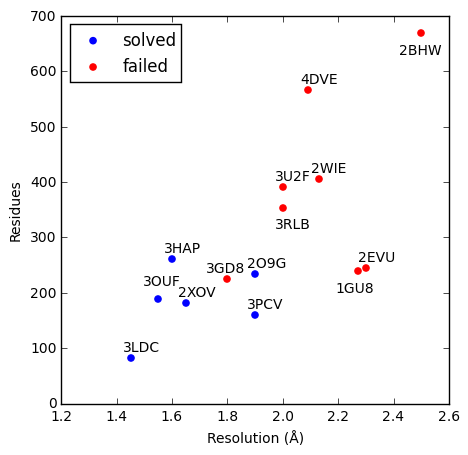

In [6]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)

solved = df_hx_summary[df_hx_summary['success'] > 0 ]
x = solved['native_pdb_resolution'].tolist()
y = solved['native_pdb_num_residues'].tolist()
ax.scatter(x, y, marker='o', color=COLOUR_SUCCESS, label='solved')
for i, txt in enumerate(solved['native_pdb_code'].tolist()):
    if txt == '3OUF':
        xytext = (-10,10)
    else:
        xytext = (-5,5)
    ax.annotate(txt, (x[i],y[i]), xytext=xytext, textcoords='offset points')

failed = df_hx_summary[df_hx_summary['success'] == 0 ]
x = failed['native_pdb_resolution'].tolist()
y = failed['native_pdb_num_residues'].tolist()
ax.scatter(x, y, marker='o', color=COLOUR_FAIL, label='failed')
for i, txt in enumerate(failed['native_pdb_code'].tolist()):
    if txt == '3GD8':
        xytext = (-15,5)
    elif txt == '3RLB':
        xytext = (-5,-15)
    elif txt == '2BHW':
        xytext = (-15,-15)
    elif txt == '1GU8':
        xytext = (-15,-15)
    else:
        xytext = (-5,5)
    ax.annotate(txt, (x[i],y[i]), xytext=xytext, textcoords='offset points')

ax.set_xlabel(u'Resolution (Å)')
ax.set_ylabel('Residues')
ax.legend(loc=2, scatterpoints=1)
plt.show()

fname = 'idealHelices_resVsResid.png'
fname = 'Figure1.png'
fig.savefig(filename=fname, dpi=DPI)

In [7]:
#print ("Max resolution solved: ",solved['PDB'][solved['Resolution'] == solved['Resolution'].max()])
# print("Max resolution solved: ",solved['Resolution'].max())
# print("Max size solved: ",solved['Residues'].max())
# print("Smallest failed ",failed[failed['Residues'] < solved['Residues'].max()]['PDB'].tolist())

In [8]:
fname = 'rosettaMembrane_allresults.csv'
df_rm = pd.read_csv(fname)
df_rm = process_df(df_rm)
df_rm_summary = summarise_df(df_rm)

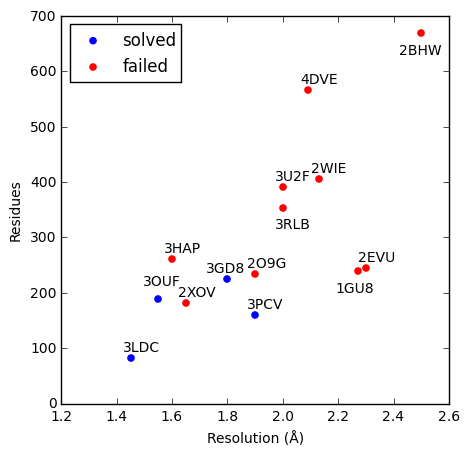

In [9]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)

xlabel = u'Resolution (Å)'
ylabel = 'Residues'

ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

solved = df_rm_summary[df_rm_summary['success'] > 0 ]
x = solved['native_pdb_resolution'].tolist()
y = solved['native_pdb_num_residues'].tolist()

# plt.scatter(solved[xlabel].tolist(), solved[ylabel].tolist(), marker='o', color=COLOUR_SUCCESS, label='solved')
ax.scatter(x, y, marker='o', color=COLOUR_SUCCESS, label='solved')
for i, txt in enumerate(solved['native_pdb_code'].tolist()):
#     xytext = (-5,5)
    if txt == '3GD8':
        xytext = (-15,5)
    elif txt == '3OUF':
        xytext = (-10,10)
    else:
        xytext = (-5,5)
    ax.annotate(txt, (x[i],y[i]), xytext=xytext, textcoords='offset points')

failed = df_rm_summary[df_rm_summary['success'] == 0 ]
x = failed['native_pdb_resolution'].tolist()
y = failed['native_pdb_num_residues'].tolist()

ax.scatter(x, y, marker='o', color=COLOUR_FAIL, label='failed')
for i, txt in enumerate(failed['native_pdb_code'].tolist()):
    if txt == '3RLB':
        xytext = (-5,-15)
    elif txt == '2BHW':
        xytext = (-15,-15)
    elif txt == '1GU8':
        xytext = (-15,-15)
    else:
        xytext = (-5,5)
    ax.annotate(txt, (x[i],y[i]), xytext=xytext, textcoords='offset points')

ax.legend(loc=2, scatterpoints=1)
plt.show()

fname = 'rosettaMembrane_resVsResid.png'
fname = 'SupFigure1.png'
fig.savefig(filename=fname, dpi=DPI)

In [10]:
# Maxcluster failed to calculate many of the TM scores so we need to use the data from the rosettaMembrane_models_tm.csv
# spreadsheet, we have to combine the data though
fname = 'rosettaMembrane_tmscores.csv'
df_rm_tm = pd.read_csv(fname, usecols=['PDB','Model','TM'])

# Need to delete 2UUI, 2BL2, 2X2V
df_rm_tm = df_rm_tm[(df_rm_tm['PDB'] != '2BL2') & (df_rm_tm['PDB'] != '2UUI') & (df_rm_tm['PDB'] != '2X2V')]

# FOR OTHER DATAFRAME Get basename so matches Model in df_rm_tm
df_rm['subcluster_centroid_model'] = df_rm['subcluster_centroid_model'].apply(lambda x: os.path.splitext(os.path.basename(x))[0])
# Need to get the basename as the truncation level is tacked on
#df_rm['subcluster_centroid_model'] = df_rm['subcluster_centroid_model'].apply(lambda x: '_'.join(x.split('_')[:-1]))

# Rename the columns we need to match
df_rm_tm.rename(columns={'PDB':'native_pdb_code', 'Model' : 'subcluster_centroid_model'}, inplace=True)

# Use merge to join on the columns
df_rm = pd.merge(df_rm_tm, df_rm, how='inner', on=['native_pdb_code', 'subcluster_centroid_model'])

# Hack - replace the ensemble_native_TM column
df_rm['ensemble_native_TM'] = df_rm['TM']

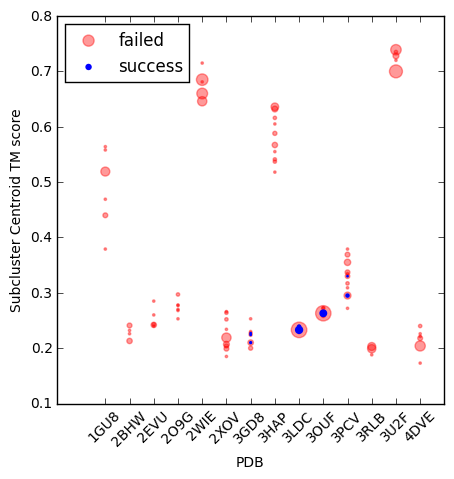

In [11]:
# Scatterplot of quality of models vs what sovles

# Need to add the Residues from the summary
solved = df_rm[df_rm['success'] == True]
failed = df_rm[df_rm['success'] == False]

# http://stackoverflow.com/questions/42246402/pandas-scatterplot-with-points-sized-by-unique-values-of-one-column-against-the
gs = solved.groupby(['native_pdb_code','ensemble_native_TM']).size().reset_index(name='num_TM')
gf = failed.groupby(['native_pdb_code','ensemble_native_TM']).size().reset_index(name='num_TM')
#gs = solved.groupby(['native_pdb_code', 'native_pdb_resolution', 'native_pdb_num_residues','ensemble_native_TM']).size().reset_index(name='num_TM')
#gf = failed.groupby(['native_pdb_code', 'native_pdb_resolution', 'native_pdb_num_residues','ensemble_native_TM']).size().reset_index(name='num_TM')

fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
#ax.set_xlabel(u'Resolution (Å)')
ax.set_xlabel('PDB')
ax.set_ylabel('Subcluster Centroid TM score')

pcodes = sorted(df_rm['native_pdb_code'].unique().tolist())
pmap = { p : i for i, p in enumerate(pcodes) }
pmapi = { i : p for p, i in pmap.iteritems() }

#ax.scatter(gf['native_pdb_resolution'].tolist(),
ax.scatter([pmap[p] for p in gf['native_pdb_code']],
#           [ n[1] for n,_ in gf ], # horrible cludge to get unique ensemble_native_TM values
#           s=gf['ensemble_native_TM'].count(),
           gf['ensemble_native_TM'].tolist(),
           s=gf['num_TM'],
           marker='o',
           color=COLOUR_FAIL,
           label='failed',
           alpha=0.4)

ax.scatter([pmap[p] for p in gs['native_pdb_code']],
            gs['ensemble_native_TM'].tolist(),
            s=gs['num_TM'],
            marker='o',
            color=COLOUR_SUCCESS,
            label='success',
            alpha=1)

pi = sorted(pmap.values())
ax.set_xticks(pi)
ax.set_xticklabels([pmapi[i] for i in pi], rotation=45)

ax.legend(loc='upper left', scatterpoints=1)
plt.show()
fname = 'rosettaMembrane_centroidTM.png'
fname = 'SupFigure2.png'
fig.savefig(filename=fname, dpi=DPI)

In [12]:
fname = 'quark_allresults.csv'
df_qk = pd.read_csv(fname)
df_qk = process_df(df_qk)
df_qk_summary = summarise_df(df_qk)

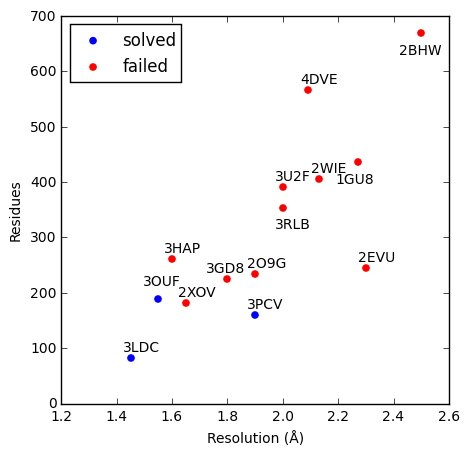

In [13]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)

xlabel = u'Resolution (Å)'
ylabel = 'Residues'

ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

solved = df_qk_summary[df_qk_summary['success'] > 0 ]
x = solved['native_pdb_resolution'].tolist()
y = solved['native_pdb_num_residues'].tolist()
# plt.scatter(solved[xlabel].tolist(), solved[ylabel].tolist(), marker='o', color=COLOUR_SUCCESS, label='solved')
ax.scatter(x, y, marker='o', color=COLOUR_SUCCESS, label='solved')
for i, txt in enumerate(solved['native_pdb_code'].tolist()):
    xytext = (-5,5)
    if txt == '3OUF':
        xytext = (-10,10)
    ax.annotate(txt, (x[i],y[i]), xytext=xytext, textcoords='offset points')

failed = df_qk_summary[df_qk_summary['success'] == 0 ]
x = failed['native_pdb_resolution'].tolist()
y = failed['native_pdb_num_residues'].tolist()
ax.scatter(x, y, marker='o', color=COLOUR_FAIL, label='failed')
for i, txt in enumerate(failed['native_pdb_code'].tolist()):
    xytext = (-5,5)
    if txt == '3GD8':
        xytext = (-15,5)
    elif txt == '3RLB':
        xytext = (-5,-15)
    elif txt == '2BHW':
        xytext = (-15,-15)
    elif txt == '1GU8':
        xytext = (-15,-15)
    ax.annotate(txt, (x[i],y[i]), xytext=xytext, textcoords='offset points')


ax.legend(loc=2, scatterpoints=1)
plt.show()

fname = 'quark_resVsResid.png'
fname = 'SupFigure4.png'
fig.savefig(filename=fname, dpi=DPI)

In [14]:
# Again need to fix the TM scores
fname = 'quark_tmscores.csv'
df_qk_tm = pd.read_csv(fname, usecols=['structure_name','model_name','tmscore'])

# Need to delete 2UUI, 2BL2, 2X2V
df_qk_tm = df_qk_tm[(df_qk_tm['structure_name'] != '2BL2') & (df_qk_tm['structure_name'] != '2UUI') & (df_qk_tm['structure_name'] != '2X2V')]

# Rename the columns we need to match
df_qk_tm.rename(columns={'structure_name':'native_pdb_code', 'model_name' : 'subcluster_centroid_model'}, inplace=True)

# FOR OTHER DATAFRAME Get basename so matches Model in df_rm_tm
df_qk['subcluster_centroid_model'] = df_qk['subcluster_centroid_model'].apply(lambda x: os.path.splitext(os.path.basename(x))[0] if str(x) != "nan" else x)
# Need to get the basename as the truncation level is tacked on
df_qk['subcluster_centroid_model'] = df_qk['subcluster_centroid_model'].apply(lambda x: '_'.join(x.split('_')[:-1]) if str(x) != "nan" else x)

df_qk = pd.merge(df_qk_tm, df_qk, how='inner', on=['native_pdb_code', 'subcluster_centroid_model'])

# Again hack to overwrite subcluster_centroid_model
# Hack - replace the ensemble_native_TM column
df_qk['ensemble_native_TM'] = df_qk['tmscore']

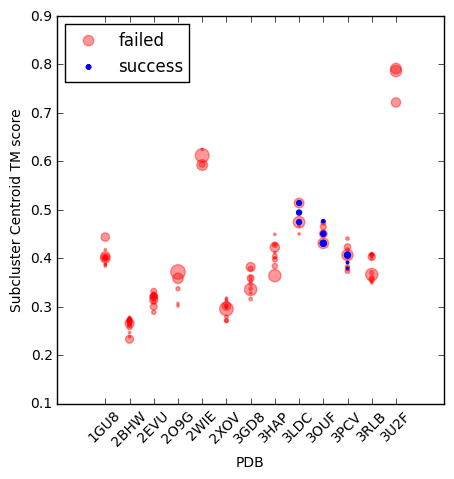

In [15]:
# Scatterplot of quality of models vs what solves

# Need to add the Residues from the summary
solved = df_qk[df_qk['success'] == True]
failed = df_qk[df_qk['success'] == False]

# http://stackoverflow.com/questions/42246402/pandas-scatterplot-with-points-sized-by-unique-values-of-one-column-against-the
gs = solved.groupby(['native_pdb_code','ensemble_native_TM']).size().reset_index(name='num_TM')
gf = failed.groupby(['native_pdb_code','ensemble_native_TM']).size().reset_index(name='num_TM')
#gs = solved.groupby(['native_pdb_code', 'native_pdb_resolution', 'native_pdb_num_residues','ensemble_native_TM']).size().reset_index(name='num_TM')
#gf = failed.groupby(['native_pdb_code', 'native_pdb_resolution', 'native_pdb_num_residues','ensemble_native_TM']).size().reset_index(name='num_TM')

fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
#ax.set_xlabel(u'Resolution (Å)')
ax.set_xlabel('PDB')
ax.set_ylabel('Subcluster Centroid TM score')

pcodes = sorted(df_qk['native_pdb_code'].unique().tolist())
pmap = { p : i for i, p in enumerate(pcodes) }
pmapi = { i : p for p, i in pmap.iteritems() }

#ax.scatter(gf['native_pdb_resolution'].tolist(),
ax.scatter([pmap[p] for p in gf['native_pdb_code']],
#           [ n[1] for n,_ in gf ], # horrible cludge to get unique ensemble_native_TM values
#           s=gf['ensemble_native_TM'].count(),
           gf['ensemble_native_TM'].tolist(),
           s=gf['num_TM'],
           marker='o',
           color=COLOUR_FAIL,
           label='failed',
           alpha=0.4)

ax.scatter([pmap[p] for p in gs['native_pdb_code']],
            gs['ensemble_native_TM'].tolist(),
            s=gs['num_TM'],
            marker='o',
            color=COLOUR_SUCCESS,
            label='success',
            alpha=1)

pi = sorted(pmap.values())
ax.set_xticks(pi)
ax.set_xticklabels([pmapi[i] for i in pi], rotation=45)

ax.legend(loc='upper left', scatterpoints=1)
plt.show()
fname = 'quark_centroidTM.png'
fname = 'SupFigure5.png'
fig.savefig(filename=fname, dpi=DPI)

In [16]:
fname = 'tm_gremlin0.0_shelxe14_allresults.csv'
df_gm = pd.read_csv(fname)
df_gm = process_df(df_gm)
df_gm_summary = summarise_df(df_gm)

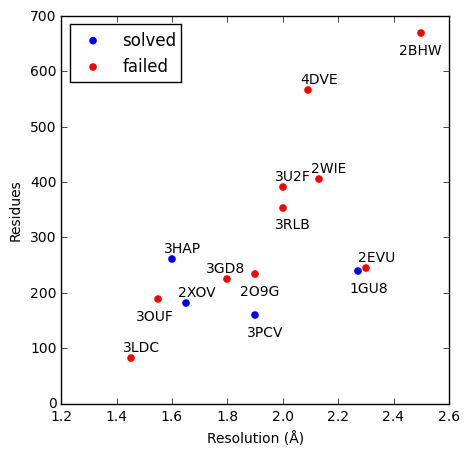

In [17]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
# figure_1 = plt.figure(figsize=(5, 5), dpi=100)

xlabel = u'Resolution (Å)'
ylabel = 'Residues'

ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

solved = df_gm_summary[df_gm_summary['success'] > 0 ]
x = solved['native_pdb_resolution'].tolist()
y = solved['native_pdb_num_residues'].tolist()
# plt.scatter(solved[xlabel].tolist(), solved[ylabel].tolist(), marker='o', color=COLOUR_SUCCESS, label='solved')
ax.scatter(x, y, marker='o', color=COLOUR_SUCCESS, label='solved')
for i, txt in enumerate(solved['native_pdb_code'].tolist()):
    xytext = (-5,5)
    if txt == '3PCV':
        xytext = (-5,-15)
    elif txt == '1GU8':
        xytext = (-5,-15)
    ax.annotate(txt, (x[i],y[i]), xytext=xytext, textcoords='offset points')

failed = df_gm_summary[df_gm_summary['success'] == 0 ]
x = failed['native_pdb_resolution'].tolist()
y = failed['native_pdb_num_residues'].tolist()
ax.scatter(x, y, marker='o', color=COLOUR_FAIL, label='failed')
for i, txt in enumerate(failed['native_pdb_code'].tolist()):
    xytext = (-5,5)
    if txt == '3RLB':
        xytext = (-5,-15)
    elif txt == '2BHW':
        xytext = (-15,-15)
    elif txt == '2O9G':
        xytext = (-10,-15)
    elif txt == '3OUF':
        xytext = (-15,-15)
    elif txt == '3GD8':
        xytext = (-15,5)
    ax.annotate(txt, (x[i],y[i]), xytext=xytext, textcoords='offset points')

ax.legend(loc=2, scatterpoints=1)
plt.show()

fname = 'gremlinCut0.0_resVsResid.png'
fname = 'SupFigure6.png'
fig.savefig(filename=fname, dpi=DPI)

In [18]:
# Again need to fix the TM scores
fname = 'tm_gremlin0.0_shelxe14_tmscores.csv'
df_gm_tm = pd.read_csv(fname, usecols=['structure_name','model_name','tmscore'])

# Need to delete 2UUI, 2BL2, 2X2V
df_gm_tm = df_gm_tm[(df_gm_tm['structure_name'] != '2BL2') & (df_gm_tm['structure_name'] != '2UUI') & (df_gm_tm['structure_name'] != '2X2V')]

# Rename the columns we need to match
df_gm_tm.rename(columns={'structure_name':'native_pdb_code', 'model_name' : 'subcluster_centroid_model'}, inplace=True)

# FOR OTHER DATAFRAME Get basename so matches Model in df_rm_tm
df_gm['subcluster_centroid_model'] = df_gm['subcluster_centroid_model'].apply(lambda x: os.path.splitext(os.path.basename(x))[0])
# Need to get the basename as the truncation level is tacked on
df_gm['subcluster_centroid_model'] = df_gm['subcluster_centroid_model'].apply(lambda x: '_'.join(x.split('_')[:-1]))

df_gm = pd.merge(df_gm_tm, df_gm, how='inner', on=['native_pdb_code', 'subcluster_centroid_model'])

# Again hack to overwrite subcluster_centroid_model
# Hack - replace the ensemble_native_TM column
df_gm['ensemble_native_TM'] = df_gm['tmscore']

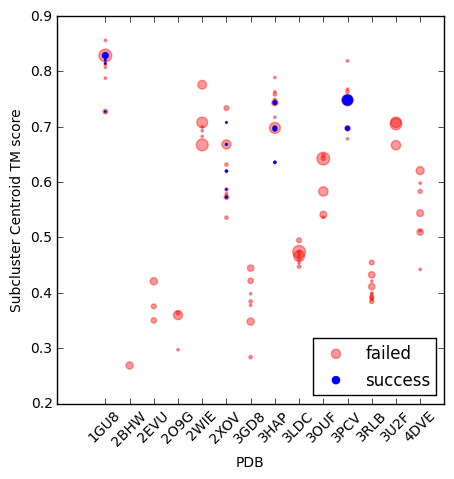

In [19]:
# Scatterplot of quality of models vs what solves

# Need to add the Residues from the summary
solved = df_gm[df_gm['success'] == True]
failed = df_gm[df_gm['success'] == False]

# http://stackoverflow.com/questions/42246402/pandas-scatterplot-with-points-sized-by-unique-values-of-one-column-against-the
gs = solved.groupby(['native_pdb_code','ensemble_native_TM']).size().reset_index(name='num_TM')
gf = failed.groupby(['native_pdb_code','ensemble_native_TM']).size().reset_index(name='num_TM')
#gs = solved.groupby(['native_pdb_code', 'native_pdb_resolution', 'native_pdb_num_residues','ensemble_native_TM']).size().reset_index(name='num_TM')
#gf = failed.groupby(['native_pdb_code', 'native_pdb_resolution', 'native_pdb_num_residues','ensemble_native_TM']).size().reset_index(name='num_TM')

fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
#ax.set_xlabel(u'Resolution (Å)')
ax.set_xlabel('PDB')
ax.set_ylabel('Subcluster Centroid TM score')

pcodes = sorted(df_gm['native_pdb_code'].unique().tolist())
pmap = { p : i for i, p in enumerate(pcodes) }
pmapi = { i : p for p, i in pmap.iteritems() }

#ax.scatter(gf['native_pdb_resolution'].tolist(),
ax.scatter([pmap[p] for p in gf['native_pdb_code']],
#           [ n[1] for n,_ in gf ], # horrible cludge to get unique ensemble_native_TM values
#           s=gf['ensemble_native_TM'].count(),
           gf['ensemble_native_TM'].tolist(),
           s=gf['num_TM'],
           marker='o',
           color=COLOUR_FAIL,
           label='failed',
           alpha=0.4)

ax.scatter([pmap[p] for p in gs['native_pdb_code']],
            gs['ensemble_native_TM'].tolist(),
            s=gs['num_TM'],
            marker='o',
            color=COLOUR_SUCCESS,
            label='success',
            alpha=1)

pi = sorted(pmap.values())
ax.set_xticks(pi)
ax.set_xticklabels([pmapi[i] for i in pi], rotation=45)

ax.legend(loc='lower right', scatterpoints=1)
plt.show()
fname = 'gremlin_centroidTM.png'
fname = 'SupFigure7.png'
fig.savefig(filename=fname, dpi=DPI)

# Create a dataframe specifically for this graph
df = df_tm_summ.copy()[['Median Rosetta TM','GREMLIN cut 0.0 TM','rosettaMembrane','gremlin']]

# Create columns for colours - COLOUR_SUCCESS if solved, otherwise red
df['colours'] = np.where((df['rosettaMembrane'] > 0) | (df['gremlin'] > 0), 'b', 'r')

# Create columns for markers depending on what solved
LEGEND = OrderedDict([('Both', 'o'), ('RosettaMembrane', '^'), ('Gremlin', 'v'), ('Neither', 'x')])
df['markers'] = LEGEND['Neither']
df.ix[df['rosettaMembrane'] > 0, 'markers'] = LEGEND['RosettaMembrane']
df.ix[df['gremlin'] > 0, 'markers'] = LEGEND['Gremlin']
df.ix[(df['rosettaMembrane'] > 0) & (df['gremlin'] > 0), 'markers'] = LEGEND['Both']
#df['markers'] = np.where(,'o','x')
#df['markers'] = df['markers'].where(df['Solved'] == 0,'^') # logic is inverted

fig, ax = plt.subplots(figsize=(5, 5), dpi=100)

xlabel = 'Rosetta Membrane Median TM'
ylabel = 'Gremlin Median TM'
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

for l, m in LEGEND.iteritems():
    #ax.scatter(df['Median Rosetta TM'], df['GREMLIN cut 0.0 TM'], c=df['colours'].tolist() , marker=df['markers'].tolist())
    x = df[df['markers'] == m ]['Median Rosetta TM']
    y = df[df['markers'] == m ]['GREMLIN cut 0.0 TM']
    c = df[df['markers'] == m ]['colours']
    ax.scatter(x, y, c=c , marker=m, label=l)

#ax.plot(ax.get_xlim(), ax.get_ylim(), ls="-", c=".3")
#ax.plot([0, 1], [0, 1], ls="-", c=".3", zorder=0)
ax.plot([0, 1], [0, 1], ls='--', zorder=0)

ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set(aspect=1.0)

ax.legend(title='Solved with:', loc='lower right', scatterpoints=1, fontsize='small')
fig.savefig(filename='gremlinVsRosettaTM.png', dpi=DPI)

In [20]:
fname = 'ccmpred_fade1.0_weight1.0_dtn5_allresults.csv'
df_ccmpred = pd.read_csv(fname)
# Fix for  different model names (subcluster_centroid_model contain truncation id)
df_ccmpred['subcluster_centroid_model'] = df_ccmpred['subcluster_centroid_model'].apply(lambda x: os.path.basename(x))
df_ccmpred['subcluster_centroid_model'] = df_ccmpred['subcluster_centroid_model'].apply(lambda x: '_'.join(x.split('_')[:2]))
df_ccmpred = process_df(df_ccmpred)
df_ccmpred_summary = summarise_df(df_ccmpred)
# Fix TM scores
fname = 'ccmpred_fade1.0_weight1.0_dtn5_tmscores.csv'
df_ccmpred_tm = pd.read_csv(fname)
df_ccmpred = pd.merge(df_ccmpred_tm, df_ccmpred, how='inner', on=['native_pdb_code', 'subcluster_centroid_model'])
df_ccmpred['ensemble_native_TM'] = df_ccmpred['tmscore']

fname = 'membrain_fade1.0_weight1.0_dtn5_allresults.csv'
df_membrain = pd.read_csv(fname)
# Fix for  different model names (subcluster_centroid_model contain truncation id)
df_membrain['subcluster_centroid_model'] = df_membrain['subcluster_centroid_model'].apply(lambda x: os.path.basename(x))
df_membrain['subcluster_centroid_model'] = df_membrain['subcluster_centroid_model'].apply(lambda x: '_'.join(x.split('_')[:2]))
df_membrain = process_df(df_membrain)
df_membrain_summary = summarise_df(df_membrain)
# Fix TM scores
fname = 'membrain_fade1.0_weight1.0_dtn5_tmscores.csv'
df_membrain_tm = pd.read_csv(fname)
df_membrain = pd.merge(df_membrain_tm, df_membrain, how='inner', on=['native_pdb_code', 'subcluster_centroid_model'])
df_membrain['ensemble_native_TM'] = df_membrain['tmscore']

fname = 'metapsicov.stage1_fade1.0_weight1.0_dtn5_allresults.csv'
df_metapsicov = pd.read_csv(fname)
# Fix for  different model names (subcluster_centroid_model contain truncation id)
df_metapsicov['subcluster_centroid_model'] = df_metapsicov['subcluster_centroid_model'].apply(lambda x: os.path.basename(x) if str(x) != "nan" else x)
df_metapsicov['subcluster_centroid_model'] = df_metapsicov['subcluster_centroid_model'].apply(lambda x: '_'.join(x.split('_')[:2]) if str(x) != "nan" else x)
df_metapsicov = process_df(df_metapsicov)
df_metapsicov_summary = summarise_df(df_metapsicov)
# Fix TM scores
fname = 'metapsicov.stage1_fade1.0_weight1.0_dtn5_tmscores.csv'
df_metapsicov_tm = pd.read_csv(fname)
df_metapsicov = pd.merge(df_metapsicov_tm, df_metapsicov, how='inner', on=['native_pdb_code', 'subcluster_centroid_model'])
df_metapsicov['ensemble_native_TM'] = df_metapsicov['tmscore']

In [21]:
#df_metapsicov.query('(native_pdb_code == "4DVE") & (ensemble_name == "c1_t90_r3_polyAla")')
df_metapsicov[(df_metapsicov['native_pdb_code'] == '2O9G') & (df_metapsicov['ensemble_name'] == "c1_t59_r3_polyAla")]['ensemble_native_TM']

126    0.4194
Name: ensemble_native_TM, dtype: float64

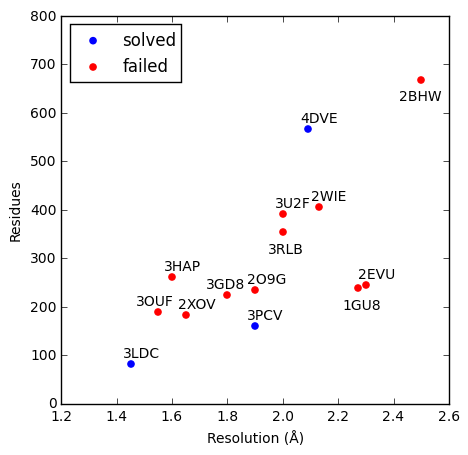

In [22]:
# ccmpred summary
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)

ax.set_xlabel(u'Resolution (Å)')
ax.set_ylabel('Residues')

solved = df_ccmpred_summary[df_ccmpred_summary['success'] > 0 ]
x = solved['native_pdb_resolution'].tolist()
y = solved['native_pdb_num_residues'].tolist()
# plt.scatter(solved[xlabel].tolist(), solved[ylabel].tolist(), marker='o', color=COLOUR_SUCCESS, label='solved')
ax.scatter(x, y, marker='o', color=COLOUR_SUCCESS, label='solved')
for i, txt in enumerate(solved['native_pdb_code'].tolist()):
    xytext = (-5,5)
#     if txt == '3GD8':
#         xytext = (-15,5)
#     elif txt == '3OUF':
#         xytext = (-10,10)
    ax.annotate(txt, (x[i],y[i]), xytext=xytext, textcoords='offset points')

failed = df_ccmpred_summary[df_ccmpred_summary['success'] == 0 ]
x = failed['native_pdb_resolution'].tolist()
y = failed['native_pdb_num_residues'].tolist()
ax.scatter(x, y, marker='o', color=COLOUR_FAIL, label='failed')
for i, txt in enumerate(failed['native_pdb_code'].tolist()):
    xytext = (-5,5)
    if txt == '1GU8':
        xytext = (-10,-15)
    elif txt == '2BHW':
        xytext = (-15,-15)
    elif txt == '3RLB':
        xytext = (-10,-15)
    elif txt == '3GD8':
        xytext = (-15,5)
    elif txt == '3OUF':
        xytext = (-15,5)
    ax.annotate(txt, (x[i],y[i]), xytext=xytext, textcoords='offset points')


ax.legend(loc=2, scatterpoints=1)
plt.show()

fname = 'ccmpred_resVsResid.png'
fname = 'SupFigure8.png'
fig.savefig(filename=fname, dpi=DPI)

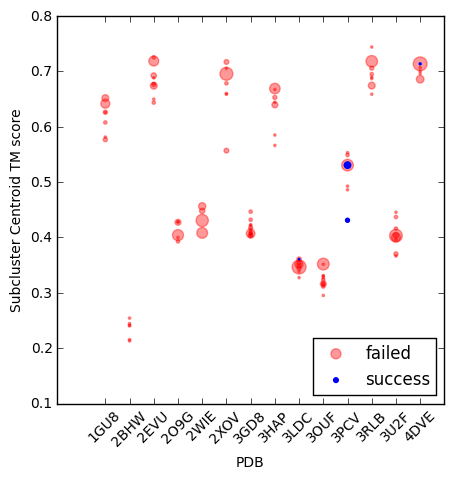

In [23]:
# Scatterplot of quality of models vs what solves

# Need to add the Residues from the summary
solved = df_ccmpred[df_ccmpred['success'] == True]
failed = df_ccmpred[df_ccmpred['success'] == False]

# http://stackoverflow.com/questions/42246402/pandas-scatterplot-with-points-sized-by-unique-values-of-one-column-against-the
gs = solved.groupby(['native_pdb_code','ensemble_native_TM']).size().reset_index(name='num_TM')
gf = failed.groupby(['native_pdb_code','ensemble_native_TM']).size().reset_index(name='num_TM')
#gs = solved.groupby(['native_pdb_code', 'native_pdb_resolution', 'native_pdb_num_residues','ensemble_native_TM']).size().reset_index(name='num_TM')
#gf = failed.groupby(['native_pdb_code', 'native_pdb_resolution', 'native_pdb_num_residues','ensemble_native_TM']).size().reset_index(name='num_TM')

fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
#ax.set_xlabel(u'Resolution (Å)')
ax.set_xlabel('PDB')
ax.set_ylabel('Subcluster Centroid TM score')

pcodes = sorted(df_membrain['native_pdb_code'].unique().tolist())
pmap = { p : i for i, p in enumerate(pcodes) }
pmapi = { i : p for p, i in pmap.iteritems() }

#ax.scatter(gf['native_pdb_resolution'].tolist(),
ax.scatter([pmap[p] for p in gf['native_pdb_code']],
#           [ n[1] for n,_ in gf ], # horrible cludge to get unique ensemble_native_TM values
#           s=gf['ensemble_native_TM'].count(),
           gf['ensemble_native_TM'].tolist(),
           s=gf['num_TM'],
           marker='o',
           color=COLOUR_FAIL,
           label='failed',
           alpha=0.4)

ax.scatter([pmap[p] for p in gs['native_pdb_code']],
            gs['ensemble_native_TM'].tolist(),
            s=gs['num_TM'],
            marker='o',
            color=COLOUR_SUCCESS,
            label='success',
            alpha=1)

pi = sorted(pmap.values())
ax.set_xticks(pi)
ax.set_xticklabels([pmapi[i] for i in pi], rotation=45)

ax.legend(loc='lower right', scatterpoints=1)
plt.show()
fname = 'ccmpred_centroidTM.png'
fname = 'SupFigure9.png'
fig.savefig(filename=fname, dpi=DPI)


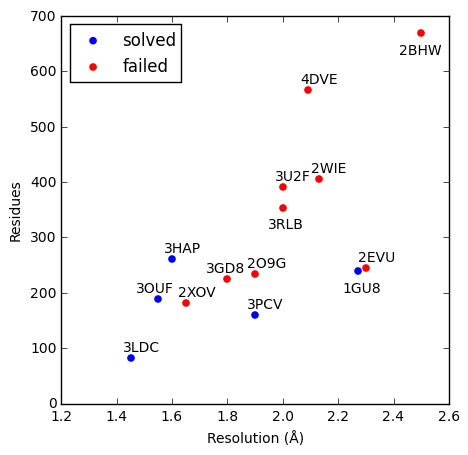

In [24]:
# membrain summary
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)

ax.set_xlabel(u'Resolution (Å)')
ax.set_ylabel('Residues')

solved = df_membrain_summary[df_membrain_summary['success'] > 0 ]
x = solved['native_pdb_resolution'].tolist()
y = solved['native_pdb_num_residues'].tolist()
# plt.scatter(solved[xlabel].tolist(), solved[ylabel].tolist(), marker='o', color=COLOUR_SUCCESS, label='solved')
ax.scatter(x, y, marker='o', color=COLOUR_SUCCESS, label='solved')
for i, txt in enumerate(solved['native_pdb_code'].tolist()):
    xytext = (-5,5)
    if txt == '1GU8':
        xytext = (-10,-15)
    elif txt == '3OUF':
        xytext = (-15,5)
    ax.annotate(txt, (x[i],y[i]), xytext=xytext, textcoords='offset points')

failed = df_membrain_summary[df_membrain_summary['success'] == 0 ]
x = failed['native_pdb_resolution'].tolist()
y = failed['native_pdb_num_residues'].tolist()
ax.scatter(x, y, marker='o', color=COLOUR_FAIL, label='failed')
for i, txt in enumerate(failed['native_pdb_code'].tolist()):
    xytext = (-5,5)
    if txt == '2BHW':
        xytext = (-15,-15)
    elif txt == '3RLB':
        xytext = (-10,-15)
    elif txt == '3GD8':
        xytext = (-15,5)
    ax.annotate(txt, (x[i],y[i]), xytext=xytext, textcoords='offset points')

ax.legend(loc=2, scatterpoints=1)
plt.show()

fname = 'membrain_resVsResid.png'
fname = 'SupFigure10.png'
fig.savefig(filename=fname, dpi=DPI)

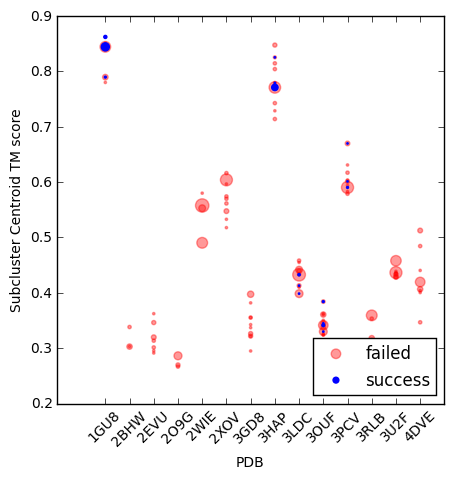

In [25]:
# Scatterplot of quality of models vs what solves

# Need to add the Residues from the summary
solved = df_membrain[df_membrain['success'] == True]
failed = df_membrain[df_membrain['success'] == False]

# http://stackoverflow.com/questions/42246402/pandas-scatterplot-with-points-sized-by-unique-values-of-one-column-against-the
gs = solved.groupby(['native_pdb_code','ensemble_native_TM']).size().reset_index(name='num_TM')
gf = failed.groupby(['native_pdb_code','ensemble_native_TM']).size().reset_index(name='num_TM')
#gs = solved.groupby(['native_pdb_code', 'native_pdb_resolution', 'native_pdb_num_residues','ensemble_native_TM']).size().reset_index(name='num_TM')
#gf = failed.groupby(['native_pdb_code', 'native_pdb_resolution', 'native_pdb_num_residues','ensemble_native_TM']).size().reset_index(name='num_TM')

fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
#ax.set_xlabel(u'Resolution (Å)')
ax.set_xlabel('PDB')
ax.set_ylabel('Subcluster Centroid TM score')

pcodes = sorted(df_membrain['native_pdb_code'].unique().tolist())
pmap = { p : i for i, p in enumerate(pcodes) }
pmapi = { i : p for p, i in pmap.iteritems() }

#ax.scatter(gf['native_pdb_resolution'].tolist(),
ax.scatter([pmap[p] for p in gf['native_pdb_code']],
#           [ n[1] for n,_ in gf ], # horrible cludge to get unique ensemble_native_TM values
#           s=gf['ensemble_native_TM'].count(),
           gf['ensemble_native_TM'].tolist(),
           s=gf['num_TM'],
           marker='o',
           color=COLOUR_FAIL,
           label='failed',
           alpha=0.4)

ax.scatter([pmap[p] for p in gs['native_pdb_code']],
            gs['ensemble_native_TM'].tolist(),
            s=gs['num_TM'],
            marker='o',
            color=COLOUR_SUCCESS,
            label='success',
            alpha=1)

pi = sorted(pmap.values())
ax.set_xticks(pi)
ax.set_xticklabels([pmapi[i] for i in pi], rotation=45)

ax.legend(loc='lower right', scatterpoints=1)
plt.show()
fname = 'membrain_centroidTM.png'
fname = 'SupFigure11.png'
fig.savefig(filename=fname, dpi=DPI)


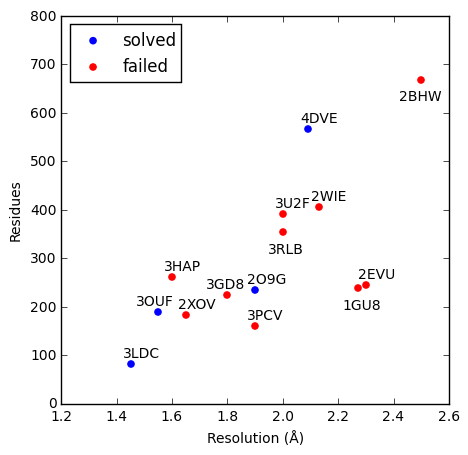

In [26]:
# metapsicov summary
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)

ax.set_xlabel(u'Resolution (Å)')
ax.set_ylabel('Residues')

solved = df_metapsicov_summary[df_metapsicov_summary['success'] > 0 ]
x = solved['native_pdb_resolution'].tolist()
y = solved['native_pdb_num_residues'].tolist()
# plt.scatter(solved[xlabel].tolist(), solved[ylabel].tolist(), marker='o', color=COLOUR_SUCCESS, label='solved')
ax.scatter(x, y, marker='o', color=COLOUR_SUCCESS, label='solved')
for i, txt in enumerate(solved['native_pdb_code'].tolist()):
    xytext = (-5,5)
    if txt == '3OUF':
        xytext = (-15,5)
    ax.annotate(txt, (x[i],y[i]), xytext=xytext, textcoords='offset points')

failed = df_metapsicov_summary[df_metapsicov_summary['success'] == 0 ]
x = failed['native_pdb_resolution'].tolist()
y = failed['native_pdb_num_residues'].tolist()
ax.scatter(x, y, marker='o', color=COLOUR_FAIL, label='failed')
for i, txt in enumerate(failed['native_pdb_code'].tolist()):
    xytext = (-5,5)
    if txt == '1GU8':
        xytext = (-10,-15)
    elif txt == '2BHW':
        xytext = (-15,-15)
    elif txt == '3RLB':
        xytext = (-10,-15)
    elif txt == '3GD8':
        xytext = (-15,5)
    ax.annotate(txt, (x[i],y[i]), xytext=xytext, textcoords='offset points')

ax.legend(loc=2, scatterpoints=1)
plt.show()

fname = 'metapsicov_resVsResid.png'
fname = 'SupFigure12.png'
fig.savefig(filename=fname, dpi=DPI)

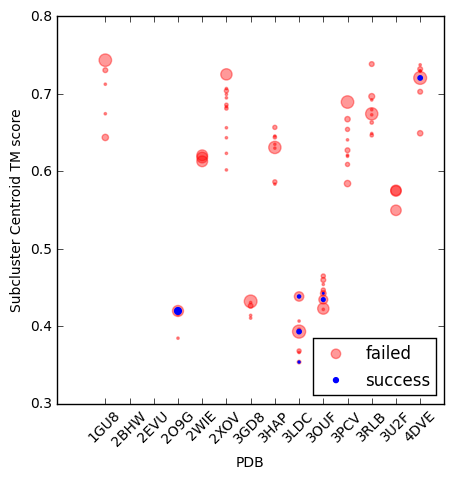

In [27]:
# Scatterplot of quality of models vs what solves

# Need to add the Residues from the summary
solved = df_metapsicov[df_metapsicov['success'] == True]
failed = df_metapsicov[df_metapsicov['success'] == False]

# http://stackoverflow.com/questions/42246402/pandas-scatterplot-with-points-sized-by-unique-values-of-one-column-against-the
gs = solved.groupby(['native_pdb_code','ensemble_native_TM']).size().reset_index(name='num_TM')
gf = failed.groupby(['native_pdb_code','ensemble_native_TM']).size().reset_index(name='num_TM')
#gs = solved.groupby(['native_pdb_code', 'native_pdb_resolution', 'native_pdb_num_residues','ensemble_native_TM']).size().reset_index(name='num_TM')
#gf = failed.groupby(['native_pdb_code', 'native_pdb_resolution', 'native_pdb_num_residues','ensemble_native_TM']).size().reset_index(name='num_TM')

fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
#ax.set_xlabel(u'Resolution (Å)')
ax.set_xlabel('PDB')
ax.set_ylabel('Subcluster Centroid TM score')

pcodes = sorted(df_membrain['native_pdb_code'].unique().tolist())
pmap = { p : i for i, p in enumerate(pcodes) }
pmapi = { i : p for p, i in pmap.iteritems() }

#ax.scatter(gf['native_pdb_resolution'].tolist(),
ax.scatter([pmap[p] for p in gf['native_pdb_code']],
#           [ n[1] for n,_ in gf ], # horrible cludge to get unique ensemble_native_TM values
#           s=gf['ensemble_native_TM'].count(),
           gf['ensemble_native_TM'].tolist(),
           s=gf['num_TM'],
           marker='o',
           color=COLOUR_FAIL,
           label='failed',
           alpha=0.4)

ax.scatter([pmap[p] for p in gs['native_pdb_code']],
            gs['ensemble_native_TM'].tolist(),
            s=gs['num_TM'],
            marker='o',
            color=COLOUR_SUCCESS,
            label='success',
            alpha=1)

pi = sorted(pmap.values())
ax.set_xticks(pi)
ax.set_xticklabels([pmapi[i] for i in pi], rotation=45)

ax.legend(loc='lower right', scatterpoints=1)
plt.show()
fname = 'metapsicov_centroidTM.png'
fname = 'SupFigure13.png'
fig.savefig(filename=fname, dpi=DPI)


In [28]:
fname = 'allruns_tm.csv'
tmscore_df = pd.read_csv(fname, index_col=(0,1))

/opt/ccp4/ccp4-7.0/lib/python2.7/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


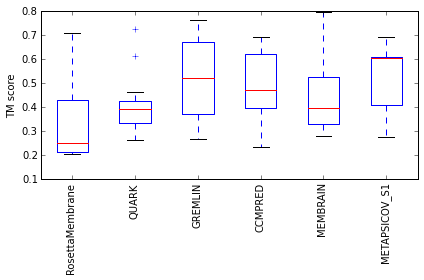

In [29]:
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

# Boxplots of  TM scores
RUNTYPES = ['rosettaMembrane', 'quark', 'gremlin', 'ccmpred', 'membrain', 'metapsicov' ]
tm_scores = [ tmscore_df.loc[r]['TM'].values for r in RUNTYPES]

#fig, ax = plt.subplots(figsize=(5, 9), dpi=100)
fig, ax = plt.subplots()
ax.boxplot(tm_scores)

labels = ['RosettaMembrane', 'QUARK', 'GREMLIN', 'CCMPRED', 'MEMBRAIN', 'METAPSICOV_S1' ]
plt.xticks([i for i in range(1,len(labels)+1)], labels, rotation='vertical')
plt.yticks([i/10.0 for i in range(1,9)])

#ax.set_xlabel('PDB')
ax.set_ylabel('TM score')

plt.show()
fname = 'tm_boxplot.png'
fname = 'Figure6.png'
fig.savefig(filename=fname, dpi=DPI)

fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
yvalues = [np.median(x) for x in tm_scores]

xvalues = []
for rtype in RUNTYPES:
    #nsolved = sum([1 if v > 0 else 0 for v in df_tm_summ[rtype].values ])
    nsolved = sum([v for v in df_tm_summ[rtype].values ])
    xvalues.append(nsolved)

ax.scatter(xvalues, yvalues)
ax.set_xlabel('Successful ensembles')
ax.set_ylabel('TM score')

for i, rtype in enumerate(RUNTYPES):
    xytext = (-20,5)
    ax.annotate(rtype, (xvalues[i],yvalues[i]), xytext=xytext, textcoords='offset points')

plt.show()
fig.savefig(filename='ntargetsVsTm.png', dpi=DPI)

/opt/ccp4/ccp4-7.0/lib/python2.7/site-packages/ipykernel/zmqshell.py:501: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


XTICKS  [  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.]
BOUND  (-2.0, 14.0)


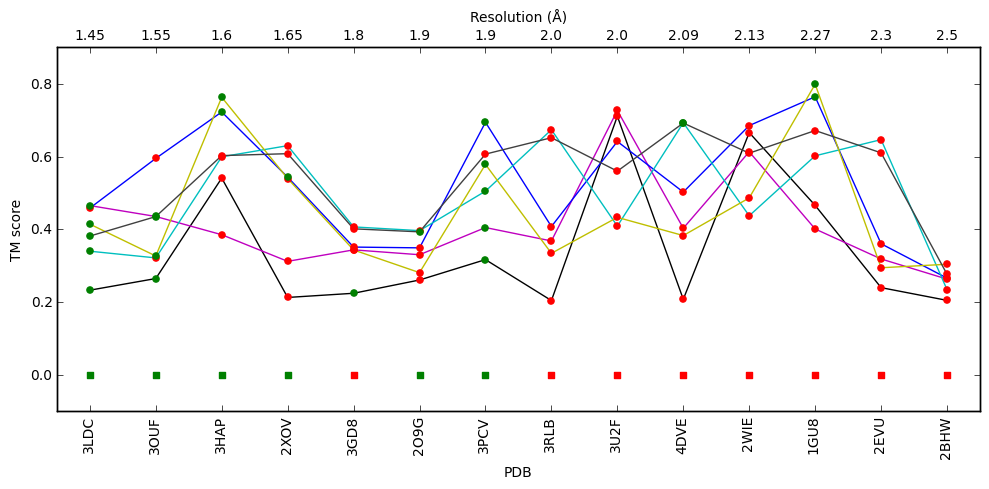

In [30]:
fname = 'allruns_tm.csv'
tmscore_df = pd.read_csv(fname, index_col=(0,1))

# copy df_tm_summ so we can strip everything out
dfs = df_tm_summ.copy()[['PDB','Resolution', 'rosettaMembrane','gremlin','ccmpred','membrain','metapsicov',
                         'Ideal Helices', 'quark', 'any_solved','I/SigI']]

# Horribleness to sort by resolution
pdbs_alpha_order = dfs['PDB'].tolist() # remember original order
dfs.sort_values('Resolution', ascending=True, inplace=True)
dfs.reset_index(inplace=True)

# Now reorder the multi-index tmscore_df
pdbs_res_order = dfs['PDB'].tolist()
res_order = [ pdbs_res_order.index(p) for p in pdbs_alpha_order]
tmscore_df.index.rename(['runtype','pdbidx'],inplace=True)
tmscore_df['res_order'] = np.nan
# Loop through the different runtypes
for i in tmscore_df.index.levels[0]: tmscore_df.loc[(i,),'res_order'] = res_order

# Need to break and then reset the index
tmscore_df.reset_index(inplace=True)
tmscore_df.sort_values(['runtype','res_order'],ascending=[True, True],inplace=True)
tmscore_df.set_index(['runtype','res_order'],inplace=True) 

#print(dfs)
#print(tmscore_df)

lines = ['-', '-', '-', '-', '-', '-' ]
colours = ['k', 'm', 'b', 'c', 'y', '0.25']

#fig = plt.figure(figsize=(10,5))
#ax = fig.add_subplot(1, 1, 1, adjustable='box', aspect=5.5)
fig, ax = plt.subplots(figsize=(10, 5), dpi=100)

TM_max = [ 0.0 for i in dfs['PDB'].index.values ]
TM_max_pdb = dfs['PDB'].values # required for ideal helix plot below
for i, rtype in enumerate(RUNTYPES + ['Ideal Helices']):
    axvalues = dfs['PDB'].index.values
    mask = [ True if s > 0 else False for s in dfs[rtype].values ]
    if rtype != 'Ideal Helices':
        ayvalues = tmscore_df.loc[rtype]['TM'].values
        ax.plot(axvalues, ayvalues, linestyle=lines[i], color=colours[i], label=rtype, marker=None, zorder=1)
    else:
        ayvalues = [0.0] * len(dfs['PDB'].index.values)
    TM_max = [ max(TM_max[i],x) for i, x in enumerate(ayvalues) ]
    for success in [False, True]:
        if success:
            xvalues = [ x for x, m in zip(axvalues,mask) if m ]
            yvalues = [ y for y, m in zip(ayvalues,mask) if m ]
            color = 'g'
            zorder = 3
        else:
            xvalues = [ x for x, m in zip(axvalues,mask) if not m ]
            yvalues = [ y for y, m in zip(ayvalues,mask) if not m ]
            color = 'r'
            zorder = 2
        if rtype != 'Ideal Helices':
            marker = 'o'
        else:
            marker = 's'
        ax.scatter(xvalues, yvalues, marker=marker, color=color, zorder=zorder)

# use an arbitrary one
ax.set_xticks(tmscore_df.loc['membrain'].index.values)
ax.set_xticklabels(tmscore_df.loc['membrain']['PDB'].values, rotation=90)
ax.set_xlabel('PDB')
ax.set_ylabel('TM score')
print("XTICKS ",ax.get_xticks())

# Create second axis with resolution
ax2 = ax.twiny()
ax2.set_xticks(ax.get_xticks())
print ("BOUND ",ax.get_xbound())
# Get upper bound dynamically
ax.set_xbound((-0.5,13.5))
ax2.set_xbound(ax.get_xbound())
ax2.set_xticklabels(dfs['Resolution'])
ax2.set_xlabel(u'Resolution (Å)')

#ax.legend()
fname = 'allTM.png'
fname = 'Figure7.png'
fig.savefig(filename=fname, dpi=DPI)

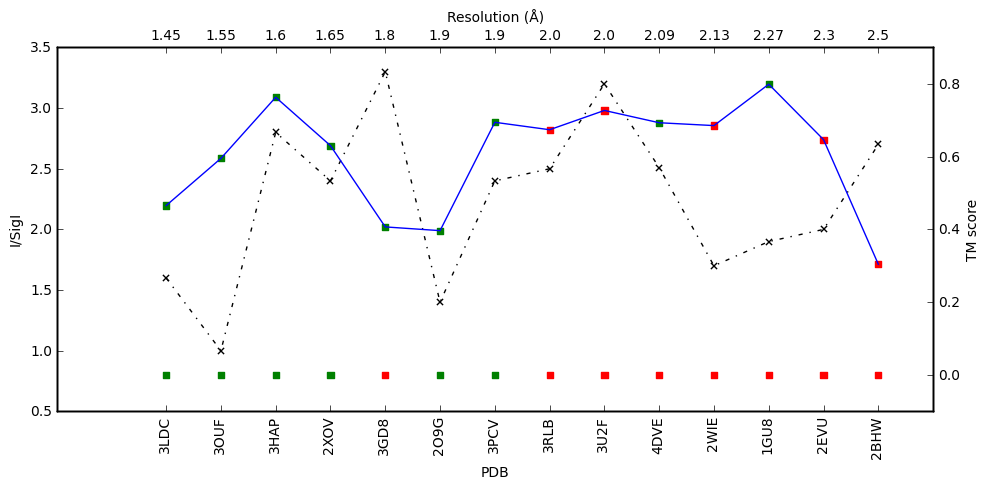

In [31]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=100)

# Shared by all
colours = ['g' if x else 'r' for x in dfs['any_solved'].values ]
xvalues = dfs['PDB'].index.values

# I/SigI
ax.scatter(xvalues, dfs['I/SigI'].values, marker='x', color='k')
ax.plot(xvalues, dfs['I/SigI'].values, linestyle='-.', color='k')

# TM_max
ax_x2 = ax.twinx()
yvalues = TM_max

ax_x2.scatter(xvalues, yvalues, marker='s', color=colours)
ax_x2.plot(xvalues, yvalues, linestyle='-', color='b')

# Ideal helices
yvalues = [0.0] * len(yvalues)
colours = ['g' if x else 'r' for x in dfs['Ideal Helices'].values ]
ax_x2.scatter(xvalues, yvalues, marker='s', color=colours)
ax_x2.set_ylabel('TM score')

# use an arbitrary one
ax.set_xticks(dfs['PDB'].index.values)
ax.set_xticklabels(dfs['PDB'].values, rotation=90)
ax.set_xlabel('PDB')
ax.set_ylabel('I/SigI')

# Create second axis with resolution
ax_y2 = ax.twiny()
ax_y2.set_xticks(ax.get_xticks())
ax_y2.set_xbound(ax.get_xbound())
ax_y2.set_xticklabels(dfs['Resolution'])
ax_y2.set_xlabel(u'Resolution (Å)')

#ax.legend()
fname = 'allISigITM.png'
fname = 'SupFigure16.png'
fig.savefig(filename=fname, dpi=DPI)

In [32]:
for rtype, df in zip(['ideal_helices', 'rosettaMembrane', 'quark', 'gremlin', 'ccmpred', 'membrain', 'metapsicov' ],
            [df_hx,df_rm,df_qk,df_gm,df_ccmpred,df_membrain,df_metapsicov]):
    df['runtype'] = rtype
df_all = pd.concat([df_hx, df_rm, df_qk, df_gm, df_ccmpred, df_membrain, df_metapsicov])

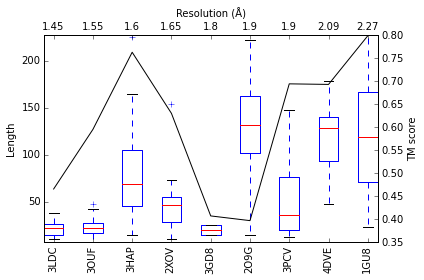

In [33]:
# Smallest/largest successful ensembles
# Stack all dataframes - ADD IDEAL HELICES
#df_all = pd.concat([df_hx,df_rm,df_qk,df_gm,df_ccmpred,df_membrain,df_metapsicov])

# Collect all successes and just keep relevant data
df_all_ok = df_all.loc[df_all['success'] > 0, ['native_pdb_code','native_pdb_resolution','num_residues']]
df_all_ok.sort_values(['native_pdb_resolution','native_pdb_code'],inplace=True)

pdbs = df_all_ok['native_pdb_code'].unique()
lengths = [ df_all_ok.loc[df_all_ok.native_pdb_code == p].num_residues for p in pdbs ]
resolutions = [ df_all_ok.loc[df_all_ok.native_pdb_code == p].native_pdb_resolution.tolist()[0] for p in pdbs ]

fig, ax = plt.subplots()
ax.boxplot(lengths)

# Add in max tm scores
TM_maxh = [ t for i, t in enumerate(TM_max) if TM_max_pdb[i] in pdbs ] # HACK
ax_x2 = ax.twinx()
ax_x2.plot([ i+1 for i in range(len(TM_maxh)) ], TM_maxh, linestyle='-', color='k')
ax_x2.set_ylabel('TM score')

labels = pdbs
ax.set_xticklabels(pdbs, rotation=90)

# Create second axis with resolution
ax_y2 = ax.twiny()
ax_y2.set_xticks(ax.get_xticks())
ax_y2.set_xbound(ax.get_xbound())
ax_y2.set_xticklabels(resolutions)
ax_y2.set_xlabel(u'Resolution (Å)')

ax.set_ylabel('Length')

ax.margins(1, 0)

plt.show()
fname = 'ensembleLen_boxplot.png'
fname = 'Figure8.png'
fig.savefig(filename=fname, dpi=DPI)

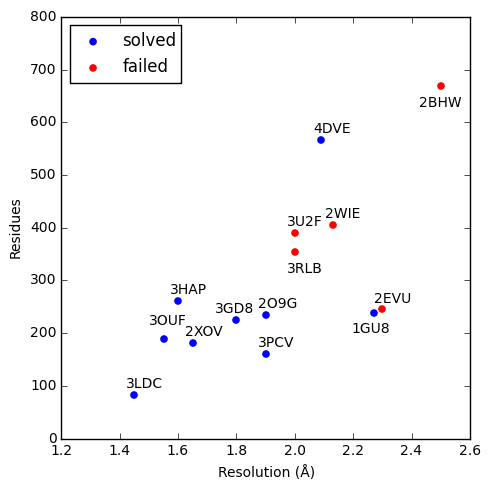

In [34]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
# figure_1 = plt.figure(figsize=(5, 5), dpi=100)

xlabel = u'Resolution (Å)'
ylabel = 'Residues'
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

solved = df_tm_summ[df_tm_summ['any_solved'] > 0 ]
x = solved['Resolution'].tolist()
y = solved['Residues'].tolist()
# plt.scatter(solved[xlabel].tolist(), solved[ylabel].tolist(), marker='o', color=COLOUR_SUCCESS, label='solved')
ax.scatter(x, y, marker='o', color=COLOUR_SUCCESS, label='solved')
for i, txt in enumerate(solved['PDB'].tolist()):
    if txt == '1GU8':
        xytext = (-15,-15)
    elif txt == '3GD8':
        xytext = (-15,5)
    elif txt == '3OUF':
        xytext = (-10,10)
    else:
        xytext = (-5,5)
    ax.annotate(txt, (x[i],y[i]), xytext=xytext, textcoords='offset points')

failed = df_tm_summ[df_tm_summ['any_solved'] == 0 ]
x = failed['Resolution'].tolist()
y = failed['Residues'].tolist()
ax.scatter(x, y, marker='o', color=COLOUR_FAIL, label='failed')
for i, txt in enumerate(failed['PDB'].tolist()):
    if txt == '3RLB':
        xytext = (-5,-15)
    elif txt == '2BHW':
        xytext = (-15,-15)
    else:
        xytext = (-5,5)
    ax.annotate(txt, (x[i],y[i]), xytext=xytext, textcoords='offset points')


ax.legend(loc=2, scatterpoints=1)
plt.show()

fname = 'anySolved_resVsResid.png'
fname = 'SupFigure14.png'
fig.savefig(filename=fname, dpi=DPI)

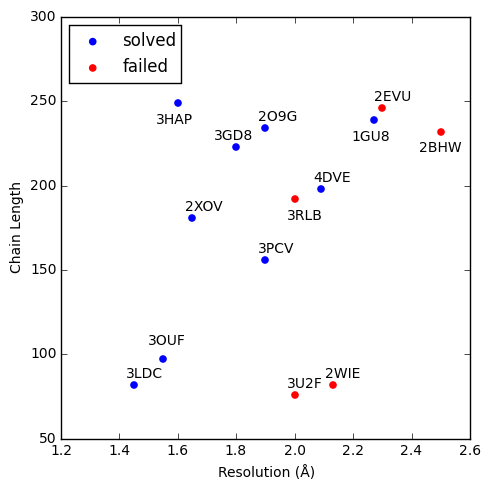

In [35]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
# figure_1 = plt.figure(figsize=(5, 5), dpi=100)

xlabel = u'Resolution (Å)'
ylabel = 'Chain Length'
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

solved = df_tm_summ[df_tm_summ['any_solved'] > 0 ]
x = solved['Resolution'].tolist()
y = solved['Chain Length'].tolist()
# plt.scatter(solved[xlabel].tolist(), solved[ylabel].tolist(), marker='o', color=COLOUR_SUCCESS, label='solved')
ax.scatter(x, y, marker='o', color=COLOUR_SUCCESS, label='solved')
for i, txt in enumerate(solved['PDB'].tolist()):
    if txt == '1GU8':
        xytext = (-15,-15)
    elif txt == '3GD8':
        xytext = (-15,5)
    elif txt == '3HAP':
        xytext = (-15,-15)
    elif txt == '3OUF':
        xytext = (-10,10)
    else:
        xytext = (-5,5)
    ax.annotate(txt, (x[i],y[i]), xytext=xytext, textcoords='offset points')

failed = df_tm_summ[df_tm_summ['any_solved'] == 0 ]
x = failed['Resolution'].tolist()
y = failed['Chain Length'].tolist()
ax.scatter(x, y, marker='o', color=COLOUR_FAIL, label='failed')
for i, txt in enumerate(failed['PDB'].tolist()):
    if txt == '3RLB':
        xytext = (-5,-15)
    elif txt == '2BHW':
        xytext = (-15,-15)
    else:
        xytext = (-5,5)
    ax.annotate(txt, (x[i],y[i]), xytext=xytext, textcoords='offset points')

ax.legend(loc='upper left', scatterpoints=1)
plt.show()

fname = 'anySolved_resVsChain.png'
fname = 'SupFigure15.png'
fig.savefig(filename=fname, dpi=DPI)

Analysis goes below

In [36]:
print(max(df_qk[df_qk['native_pdb_code'] == '3U2F']['ensemble_native_TM']))
print(df_rm[(df_rm['native_pdb_code'] == '3GD8') & (df_rm['success'] == True) ][['ensemble_name','ensemble_native_TM']])

print(df_rm['ensemble_native_TM'].median())
print(df_qk['ensemble_native_TM'].median())
print(df_gm['ensemble_native_TM'].median())
print(max(df_gm[(df_gm['native_pdb_code'] == '1GU8') & (df_gm['success'] == False) ]['ensemble_native_TM']))

rmax = df_all.loc[(df_all.native_pdb_code == '2O9G') & df_all.success].num_residues.max()
print(df_all.loc[(df_all.native_pdb_code == '2O9G') & df_all.success & (df_all.num_residues == rmax), ['ensemble_name','runtype', 'ensemble_native_TM']])

# Max TM scores for success
t = '3RLB'
t = '2WIE'
tmax = df_all[df_all.native_pdb_code == t]['ensemble_native_TM'].max()
#print(df_all.loc[df_all.ensemble_native_TM == tmax, ['ensemble_native_TM', 'runtype']])

print("GOT ",sorted(df_all.loc[ (df_all.runtype == 'rosettaMembrane') & df_all.success]['ensemble_native_TM'].unique()))

0.79159
          ensemble_name  ensemble_native_TM
441  c1_tl6_r3_reliable               0.227
447   c1_tl6_r2_allatom               0.224
453  c1_tl11_r3_polyAla               0.210
454  c1_tl11_r2_allatom               0.210
0.263
0.38543
0.66663
0.85591
          ensemble_name     runtype  ensemble_native_TM
144  c1_t95_r3_reliable  metapsicov              0.4194
GOT  [0.20999999999999999, 0.22399999999999998, 0.22699999999999998, 0.23300000000000001, 0.23899999999999999, 0.26300000000000001, 0.29499999999999998, 0.33000000000000002]
